# 无常损失计算
1. 稳定币曲线 
2. 对比 Uniswap v1/v2， Uniswap v3， Curve 

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from decimal import *
from typing import List
from attr import dataclass
from math import ceil, floor, pow

# Uniswap v1/v2

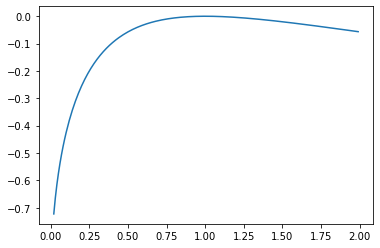

In [72]:
p0 = 1
st = 0.02
end = 2
interval = 0.01
r = np.arange(st, end, interval)

def f_lm_loss_uni_v1(r):
    return 2 * np.sqrt(r) / (1 + r) - 1

lm_loss_uni_v1 = f_lm_loss_uni_v1(r)

plt.plot(r, lm_loss_uni_v1)

# Uniswap v3

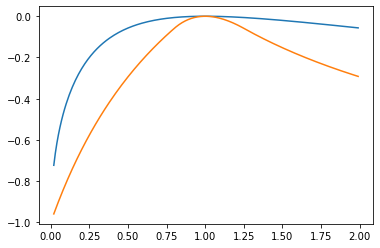

In [74]:
# pa < p0 < pb
pa = 0.8
pb = 1.25

def f_lm_loss_uni_v3(r):
    lm_loss = np.zeros(len(r))
    for i in range(len(r)):
        if r[i] < pa/p0:
            up = r[i] * p0 * (1/np.sqrt(pa) - 1/np.sqrt(pb))
            dn = (1 + r[i]) * np.sqrt(p0) - r[i] * p0 / np.sqrt(pb) - np.sqrt(pa)
            lm_loss[i] = up / dn - 1 
        elif r[i] <= pb/p0:
            lm_loss[i] = (2 * np.sqrt(r[i]) - 1 - r[i]) / (1 + r[i] - r[i] * np.sqrt(p0/pb) - np.sqrt(pa/p0))
        else:
            up = (np.sqrt(pb) - np.sqrt(pa))
            dn = (1 + r[i]) * np.sqrt(p0) - r[i] * p0 / np.sqrt(pb) - np.sqrt(pa)
            lm_loss[i] = up / dn - 1 

    
    # (2 * np.sqrt(r) - 1 - r) / (1 + r - r * np.sqrt(p0/pb) - np.sqrt(pa/p0))
    return lm_loss

lm_loss_uni_v3 = f_lm_loss_uni_v3(r)
plt.plot(r, lm_loss_uni_v1, r, lm_loss_uni_v3)

# Curve

In [75]:
def get_D_2(x,y):
    """
    close form solution to get D when n = 2 
    """
    p = 4 * x * y * (4 * A - 1)
    q = -16 * A * x * y * (x + y)
    
    c1 = - 0.5 * q
    c2 = (0.25 * q**2 + 1 / 27 * p**3)**0.5
    
    a1 = c1 + c2
    a2 = c1 - c2
    
    if a1 > 0:
        a1 = a1**(1/3)
    else:
        a1 = -(-a1)**(1/3)
        
    if a2 > 0:
        a2 = a2**(1/3)
    else:
        a2 = -(-a2)**(1/3)
        
    return a1 + a2 

# A = 10
# x = 100
# y = 100

# D = get_D_2(x,y)
# D

In [76]:
def get_y_2(D, x):
    """
    close form solution to get y when n = 2 
    """
    
    a = 1 
    b = x + D / 4 / A - D
    c = - D**3 / (16 * A * x)
        
    y = (-b + (b**2 - 4 * a * c)**0.5)  / 2 / a 
    
    return y


get_y_2(D, 30), get_y_2(D, 80), get_y_2(D, 100), get_y_2(D, 120)

(174.54844738868042, 120.19968101992225, 100.0, 80.19562819149833)

In [77]:
def get_deal_price(x1, y1, x2, y2):
    """
    真实成交价格
    """
    return  - (y2-y1) / (x2-x1)

x1, y1 = 100, 100
x2 = 70
y2 = get_y_2(D, x2)
p_deal = get_deal_price(x1, y1, x2, y2)
print(p_deal, x1, y1, x2, y2)

1.0158174179374138 100 100 70 130.47452253812241


In [78]:
def get_price(x, y, D):
    """
    当前价格
    """
    up = A * y**2 + y * (2 * A * x + D * 0.25 - A * D)
    dn = 2 * A * x * y + 0.25 * x * D - x * A * D + A * x**2     
    return up / dn

p2 = get_price(x2, y2, D)
print(p2, p_deal, x2, y2)

1.0347892042336755 1.0158174179374138 70 130.47452253812241


In [62]:
min(r_curve), max(r_curve)

(0.028984429913213813, 2.096776606024864)

Text(0, 0.5, '%')

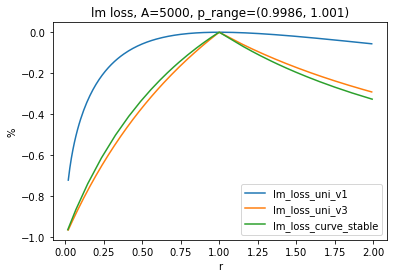

In [111]:
# x0, y0 = 100, 100 
# A = 10
# st = -99
# end = 99
# interval = 1

# dy = np.arange(st, end, interval)[::-1]

def f_lm_loss_curve_stable(dy):
    # find D
    D = get_D_2(x0,y0)
    
    lm_loss = np.zeros(len(dy))
    r = np.zeros(len(dy))
    
    for i in range(len(dy)):
        # find y
        y = y0 - dy[i] 
        
        # find x 
        x = get_y_2(D, y)
        
        # find price
        p = get_price(x, y, D)
        
        # liquidity mining
        w10 = p * x + y
        
        # hold 50/50
        w11 = p * x0 + y0
        
        lm_loss[i] = w10/w11 - 1 
        r[i] = p / p0
        
#         print(x, y, p, w10, w11, lm_loss[i])
    
    return lm_loss, r

x0, y0 = 100, 100 
pa, pb = 0.9986, 1.00140196
A = 5000

r = np.arange(0.02, 2, 0.01)
dy = np.arange(-99.99, 99.99, 0.1)[::-1]
lm_loss_uni_v1 = f_lm_loss_uni_v1(r)
lm_loss_uni_v3 = f_lm_loss_uni_v3(r)
lm_loss_curve_stable, r_curve = f_lm_loss_curve_stable(dy)

plt.figure()
plt.plot(r, lm_loss_uni_v1, r, lm_loss_uni_v3, r_curve, lm_loss_curve_stable)
# plt.plot(r, lm_loss_uni_v3, r_curve, lm_loss_curve_stable)
plt.gca().legend(('lm_loss_uni_v1','lm_loss_uni_v3', "lm_loss_curve_stable"))
# plt.gca().legend(('lm_loss_uni_v3', "lm_loss_curve_stable"))
plt.title(f"lm loss, A={A}, p_range={pa,pb}")
plt.xlabel("r")
plt.ylabel("%")

0.1 0.9974615863981353
1 0.9919501741383572
10 0.9710155700867862
100 0.8483157635659866
1000 0.3816875608970579


Text(0, 0.5, '%')

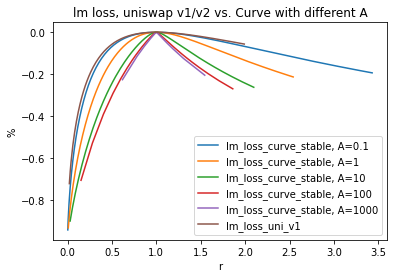

In [105]:
x0, y0 = 100, 100 

plt.figure()
for A in [0.1, 1, 10, 100, 1000]:

    dy = np.arange(-99, 99, 1)[::-1]
    # lm_loss_uni_v3 = f_lm_loss_uni_v3(r)
    lm_loss_curve_stable, r_curve = f_lm_loss_curve_stable(dy)
    
    print(A, 1- min(r_curve))
    plt.plot(r_curve, lm_loss_curve_stable, label = f"lm_loss_curve_stable, A={A}")

r = np.arange(0.02, 2, 0.01)
lm_loss_uni_v1 = f_lm_loss_uni_v1(r)

plt.plot(r, lm_loss_uni_v1, label="lm_loss_uni_v1")
plt.legend()
plt.title(f"lm loss, uniswap v1/v2 vs. Curve with different A")
plt.xlabel("r")
plt.ylabel("%")

10 0.9710155700867862
10 0.9710155700867862
10 0.9710155700867862
10 0.9710155700867862


Text(0, 0.5, '%')

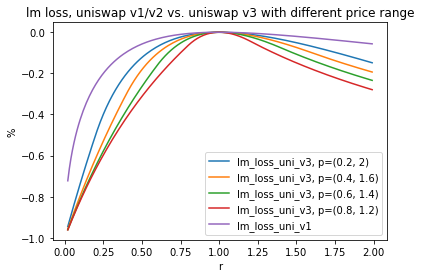

In [97]:
x0, y0 = 100, 100 
r = np.arange(0.02, 2, 0.01)

plt.figure()
for pa, pb in zip([0.2, 0.4, 0.6, 0.8],[2, 1.6, 1.4, 1.2]):
    lm_loss_uni_v3 = f_lm_loss_uni_v3(r)
    print(A, 1- min(r_curve))
    plt.plot(r, lm_loss_uni_v3, label = f"lm_loss_uni_v3, p={pa, pb}")

lm_loss_uni_v1 = f_lm_loss_uni_v1(r)
plt.plot(r, lm_loss_uni_v1, label="lm_loss_uni_v1")

plt.legend()
plt.title(f"lm loss, uniswap vs. uniswap v3 with different price range")
plt.xlabel("r")
plt.ylabel("%")

Text(0, 0.5, '%')

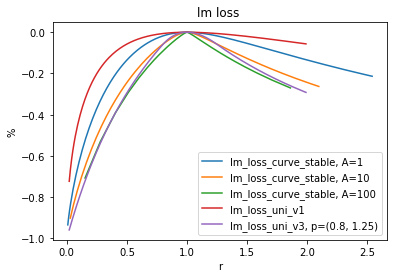

In [104]:
x0, y0 = 100, 100 
pa, pb = 0.8, 1.25 
A = 2

r = np.arange(0.02, 2, 0.01)
dy = np.arange(-99, 99, 1)[::-1]

plt.figure()
for A in [1, 10, 100]:
    lm_loss_curve_stable, r_curve = f_lm_loss_curve_stable(dy)
    plt.plot(r_curve, lm_loss_curve_stable, label = f"lm_loss_curve_stable, A={A}")

plt.plot(r, lm_loss_uni_v1, label = "lm_loss_uni_v1")
plt.plot(r, lm_loss_uni_v3, label = f"lm_loss_uni_v3, p={pa, pb}")
plt.legend()
plt.title(f"lm loss ")
plt.xlabel("r")
plt.ylabel("%")

